# Back to the Future : Time Travelling through Wikispeedia

## Part 0 : Preprocessing of data

#### Setting the environment 
Please check SETUP.md and pip_requirements.txt before running this notebook.

In [170]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import os as os
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from src.scripts.loading_data import *
from src.utils.data_utils import *
from src.scripts.plotting import *

Some definitions:
- source article: the initial point of a game
- target article: the final point that players are looking for.
- path: all the articles visited by the player during his/her game, including the source and target articles (if the latter is found)


## Part 1 : Defining the best moment to play Wikispeedia

### 1.0) Introduction
The start point of our journey is situated in the past, in 2007. We investigate possible reasons of failure at the Wikispeedia game on articles from 2007. For this purpose, we use the dataset furnished [1][2].


### 1.1) Exploring categories
The categories of the articles are given in the `categories.tsv` file.

#### 1.1.1) Cleaning the categories

In [171]:
articles2007, links2007 = loading_articles_links('2007')

categories = loading_cleaned_categories()
print(f'Shape of categories df: {categories.shape}, number of unique articles in categories.tsv: {categories.index.unique().shape}, number of articles in articles.tsv: {articles2007.article_2007.unique().shape}')

Shape of categories df: (5204, 3), number of unique articles in categories.tsv: (5204,), number of articles in articles.tsv: (4604,)


Wait a minute... There is more rows in categories than the number of articles. Some articles have more than 1 category! In addition, there are less unique appearance of articles than the total number of articles in `articles.tsv`! We want to fix that for our Sankey diagram. First let's find the 6 articles missing in `categories.tsv`.

In [172]:
articles_not_in_categories = art_not_in_cat(articles2007, categories, 'article_2007')
articles_not_in_categories

array(['Directdebit', 'Donation', 'Friend_Directdebit', 'Pikachu',
       'Sponsorship_Directdebit', 'Wowpurchase'], dtype=object)

We got them. Let's keep them here for later, it might be useful. Now let's deal with articles having several categories. First, let's find them.

In [173]:
categories.article.value_counts().value_counts()

count
1    4000
2     590
3       8
Name: count, dtype: int64

4000 articles have only 1 category, 590 have 2 categories and 8 of them have 3 categories.

In [174]:
categories_duplicated = categories.loc[categories.index.duplicated(keep=False)]
categories_duplicated

,article,category,main_category


In [175]:
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category
177,Al_Jazeera,"[Citizenship, Media]",Citizenship
178,Al_Jazeera,"[Citizenship, Politics_and_government]",Citizenship
205,Alfred_the_Great,"[People, Military_People]",People
206,Alfred_the_Great,"[People, Monarchs_of_Great_Britain]",People
297,Animation,"[Everyday_life, Computer_and_Video_games]",Everyday_life
...,...,...,...
5046,Whipworm,"[Science, Biology, Organisms]",Science
5051,White_cliffs_of_Dover,"[Geography, Geography_of_Great_Britain]",Geography
5052,White_cliffs_of_Dover,"[Geography, Geology_and_geophysics]",Geography
5068,William_Ewart_Gladstone,"[People, Historical_figures]",People


We notice that some articles have the same main category but the subcategories are different. Let's focus on the main category and get rid off the other subcategories. We keep delete one the duplicated main category for every concerned article. 

In [176]:
categories = categories.drop(index=categories.loc[categories[['article', 'main_category']].duplicated()].index)
categories

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
4,%C3%89douard_Manet,"[People, Artists]",People
...,...,...,...
5199,Zirconium,"[Science, Chemistry, Chemical_elements]",Science
5200,Zoroaster,"[People, Religious_figures_and_leaders]",People
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography
5202,Zuid-Gelders,"[Language_and_literature, Languages]",Language_and_literature


In [177]:
# let's check if this problem is solved, i.e. this command return an empty df
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category


In [178]:
# update the df containing only duplicated articles. We have deleted 90 useless rows. 
categories_duplicated = categories.loc[categories.article.duplicated(keep=False)]
categories_duplicated

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
5,%C3%89ire,[Countries],Countries
...,...,...,...
5193,Zimbabwe,[Countries],Countries
5197,Zionism,"[People, Political_People]",People
5198,Zionism,"[Religion, Religious_movements_traditions_and_...",Religion
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography


It looks better, but we still have 1013 rows to sort out. From now on, we will do purely arbitrary choices to keep only one main category.
You can find the logical reasoning and examples of paths concerned in `categories_partial_ordering.md`. Using this partial ordering, we can kick out the duplicated articles we do not want.

In [179]:


relationships = [('History', 'People'), ('Religion', 'People'), ('Language_and_literature', 'People'),
 ('Science', 'People'), ('Religion', 'History'), ('Countries', 'Geography'), ('Language_and_literature', 'Geography'), 
 ('Language_and_literature', 'Design_and_Technology'), ('Language_and_literature', 'History'), ('Science', 'Everyday_life'), 
 ('Science', 'Design_and_Technology'), ('Geography', 'Design_and_Technology'), ('Design_and_Technology', 'History'), 
 ('Mathematics', 'Everyday_life'), ('Everyday_life', 'People'), ('Everyday_life', 'History'), ('Geography', 'History'),
 ('Geography', 'Citizenship'), ('Design_and_Technology', 'Citizenship'), ('Design_and_Technology', 'Everyday_life'),
 ('Science', 'Citizenship'), ('IT', 'Business_Studies'), ('Business_Studies', 'Geography'), ('Business_Studies', 'People'),
 ('Everyday_life', 'Citizenship'), ('Business_Studies', 'Everyday_life'), ('Everyday_life', 'People'), ('IT', 'Science'),
 ('Geography', 'Everyday_life'), ('Science', 'Geography'), ('Business_Studies', 'History'), ('History', 'Citizenship'),
 ('Science', 'History'), ('Science', 'Business_Studies'), ('Art', 'Everyday_life'), ('Art', 'Business_Studies'),
 ('Art', 'Design_and_Technology'), ('Music', 'History'), ('Religion', 'Citizenship'), ('IT', 'Design_and_Technology'),
 ('IT', 'Citizenship'), ('Business_Studies', 'Citizenship'), ('Art', 'History'), ('IT', 'History'), 
 ('Science', 'Religion'), ('Language_and_literature', 'Art'), ('Design_and_Technology', 'People')]

categories, categories_duplicated = delete_duplicates_cat(categories, relationships)

print(f'Number of unique article names in categories: {categories.article.unique().size}, number of rows: {categories.article.size}.')

categories = categories.set_index('article') # easier for the following

display(categories_duplicated) # is empty, as expected

Number of unique article names in categories: 4598, number of rows: 4598.


,article,category,main_category


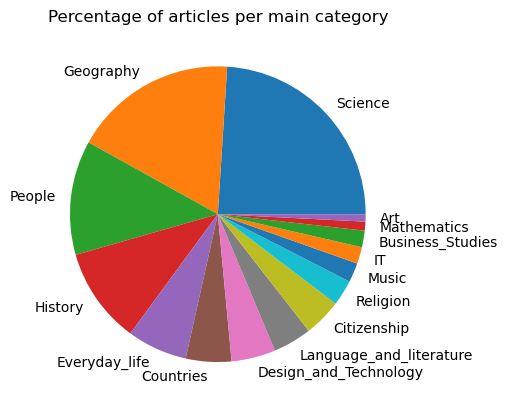

In [180]:
# NEXTSTEP:: make it pretty
plt.pie(categories.main_category.value_counts(), labels=categories.main_category.value_counts().index)
plt.title('Percentage of articles per main category');
# plt.legend()

In [181]:
flourish={"Art": "#4328e7",
          "Business_Studies": "#9654e5",
          "Citizenship": "#ff6283",
          "Countries": "#ff8800",
          "Religion": "#5b9b0f",
          "Design_and_Technology": "#ffc502",
          "Everyday_life": "#007d8e",
          "People": "#0095ff",
          "Language_and_literature": "#29dae4",
          "IT": "#88e99a",
          "History": "#019c00",
          "Mathematics": "#c11f1f",
          "Music": "#730000",
          "Geography": "#1aa7ee",
          "Science": "#e74fab"}

flourish={"Art": "#4328e7",
          "Business_Studies": "#9654e5",
          "Countries": "#ff6283",
          "Design_and_Technology": "#ff8800",
          "Religion": "#5b9b0f",
          "Everyday_life": "#ffc502",
          "Geography": "#007d8e",
          "People": "#0095ff",
          "Language_and_literature": "#29dae4",
          "IT": "#88e99a",
          "History": "#019c00",
          "Mathematics": "#c11f1f",
          "Music": "#730000",
          "Citizenship": "#1aa7ee",
          "Science": "#e74fab"}

fancy_palette = {"Art": "#daa520",
                 "Business_Studies": "#000000",
                 "Countries": "#e31a1c",
                 "Design_and_Technology": "#b2df8a",
                 "Religion": "#fdbf6f",
                 "Everyday_life": "#cab2d6",
                 "Geography": "#fb9a99",
                 "People": "#b15928",
                 "Language_and_literature": "#33a02c",
                 "IT": "#ff7f00",
                 "History": "#eeee55",
                 "Mathematics": "#6a3d9a",
                 "Music": "#888888",
                 "Citizenship": "#a6cee3",
                 "Science": "#1f78b4"}

counts = categories.main_category.value_counts()
categories['count'] = categories.main_category.apply(lambda x: counts.loc[x])
print([(c, 'inside') if counts.loc[c]/sum(counts)>0.05 else (c, 'outside') for c in categories.main_category.unique()])

fig = go.Figure(layout=go.Layout(width=800, height=500))

fig.add_trace(go.Pie(
                    labels=counts.index,
                    values=counts.values,
                    marker_colors=counts.index.map(fancy_palette).fillna("white"),
                    showlegend=False,
                    texttemplate=['%{label}<br>%{percent}' if counts.loc[c]/sum(counts)>0.05 else '%{label} %{percent}' for c in counts.index]
                    )
)            
        
fig.update_traces(textposition=['inside' if counts.loc[c]/sum(counts)>0.05 else 'outside' for c in counts.index], textinfo='percent+label')
fig.update_layout(font_size = 18,
                  title = dict({'text': f"Main categories", 'x': 0.5, 'xanchor': 'center'}),
                  margin=dict(l=20, r=20, t=50, b=20))
plotly_save_to_html(fig, 'pie_cat')

[('History', 'inside'), ('Countries', 'outside'), ('People', 'inside'), ('Business_Studies', 'outside'), ('Science', 'inside'), ('Everyday_life', 'inside'), ('Geography', 'inside'), ('Design_and_Technology', 'outside'), ('Music', 'outside'), ('IT', 'outside'), ('Language_and_literature', 'outside'), ('Mathematics', 'outside'), ('Religion', 'outside'), ('Art', 'outside'), ('Citizenship', 'outside')]


In [182]:
# Flourish custom colors
# Art: #daa520
# Business_Studies: #000000
# Countries: #e31a1c
# Design_and_Technology: #b2df8a
# Religion: #fdbf6f
# Everyday_life: #cab2d6
# Geography: #fb9a99
# People: #b15928
# Language_and_literature: #33a02c
# IT: #ff7f00
# History: #eeee55
# Mathematics: #6a3d9a
# Music: #888888
# Citizenship: #a6cee3
# Science: #1f78b4

# sankey diag skipped (already done)

#### 1.1.4) What about the distribution of the shortest paths?

In [183]:
path_finished, path_unfinished = loading_paths()

# let's check again that all the article names of interest are present in categories.tsv
articles_not_in_categories = list(articles_not_in_categories) + list(art_not_in_cat(path_finished, categories, 'start', True))

articles_not_in_categories += list(art_not_in_cat(path_finished, categories, 'end', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'start', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'target', True))

articles_not_in_categories = list(set(articles_not_in_categories))
print(f'{len(articles_not_in_categories)} articles do not appear in categories.tsv: {np.array(articles_not_in_categories)}')

# let's remove these paths
path_finished, path_unfinished = cleaned_paths(path_finished, path_unfinished, categories, articles_not_in_categories)

31 articles do not appear in categories.tsv: ['English' 'Pikachu' 'Sponsorship_Directdebit' 'Test' 'Christmas' 'Bogota'
 'Kashmir' 'Rat' 'Netbook' 'Long_peper' 'Black_ops_2' 'Sportacus'
 'Macedonia' 'Charlottes_web' 'The_Rock' 'Friend_Directdebit' 'Mustard'
 'Podcast' 'Usa' 'Rss' 'Western_Australia' 'Adolph_Hitler' '_Zebra'
 'Directdebit' 'Fats' 'Wowpurchase' 'Donation' 'Great' 'C++' 'The'
 'Georgia']
Initial number of rows in path finished: 51318, current number of rows: 51249, percentage of loss: 0.13%
Initial number of rows in path unfinished: 24875, current number of rows: 19607, percentage of loss: 21.18%


In [184]:
path_finished['lenPath'] = path_finished.path.str.len()
path_unfinished['lenPath'] = path_unfinished.path.str.len()


In [185]:
path_unfinished.type.value_counts()

type
restart    12316
timeout     7291
Name: count, dtype: int64

In [186]:

# fig, axs = plt.subplots(1, 3, figsize=(10,5))
# sns.histplot(ax=axs[0], data=path_finished, x='lenPath', bins=400, discrete=True, common_bins=True)
# sns.histplot(ax=axs[0], data=path_unfinished, x='lenPath', bins=400, discrete=True, common_bins=True)
# sns.histplot(ax=axs[1], data=path_finished, x='durationInSec', discrete=True, common_bins=True, color='k')
# sns.histplot(ax=axs[1], data=path_unfinished, hue='type', multiple='stack', x='durationInSec', discrete=True, common_bins=True)
# sns.histplot(ax=axs[2], data=path_finished, x='durationInSec', discrete=True, common_bins=True, color='k')
# sns.histplot(ax=axs[2], data=path_unfinished, hue='type', multiple='stack', x='durationInSec', discrete=True, common_bins=True)
# axs[0].set_xlim(0,30)
# axs[1].set_xlim(0,800)
# axs[2].set_xlim(0,2000)
# plt.legend(['Finished paths', 'Unfinished paths']);


# Is there games where nobody succeed?

Let's compare unfinished and finished paths with same target and beginning to check if some games lead to more withdraw than others.

In [187]:
path_finished_reduced = path_finished[['start', 'end', 'path', 'rating']].copy(deep=True).set_index(['start', 'end'], drop=True)
path_unfinished_reduced = path_unfinished[['start', 'target', 'path', 'end']].copy(deep=True).set_index(['start', 'target'], drop=True)
# Let's ignore unfinished paths where players clicked less than 2 links: we considered that these players where not serious.
path_unfinished_reduced = path_unfinished_reduced[path_unfinished_reduced.path.str.len()>2]

## Let's compute statistics about the players paths:
# finished:
stats_finished = pd.DataFrame(path_finished_reduced.index.value_counts().sort_index())
stats_finished.index.names = ['start', 'target']
stats_finished['avg_f_path'] = path_finished_reduced['path'].str.len().groupby(level=[0,1]).mean()
stats_finished['std_f_path'] = path_finished_reduced['path'].str.len().groupby(level=[0,1]).std()
stats_finished['med_f_path'] = path_finished_reduced['path'].str.len().groupby(level=[0,1]).median()

# unfinished:
stats_unfinished = pd.DataFrame(path_unfinished_reduced.index.value_counts().sort_index())
stats_unfinished['avg_unf_path'] = path_unfinished_reduced['path'].str.len().groupby(level=[0,1]).mean()
stats_unfinished['std_unf_path'] = path_unfinished_reduced['path'].str.len().groupby(level=[0,1]).std()
stats_unfinished['med_unf_path'] = path_unfinished_reduced['path'].str.len().groupby(level=[0,1]).median()


# Let's merge all these datas
stats_games = stats_finished.join(stats_unfinished, how='inner', lsuffix='_f', rsuffix='_unf').dropna().rename(columns={'count_f': 'finished', 'count_unf': 'unfinished'})

stats_games['finished'] = stats_games['finished'].astype(int)
stats_games['unfinished'] = stats_games['unfinished'].astype(int)
stats_games['tot_games_played'] = stats_games['finished']+stats_games['unfinished']
stats_games['percentage_success'] = stats_games['finished']/(stats_games['finished']+stats_games['unfinished'])*100

tot_success_rate = stats_games['finished'].sum()/(stats_games['finished'].sum()+stats_games['unfinished'].sum())*100
tot_success_rate
print(f'Success rate for a random game: {tot_success_rate:.2f}%')

display(stats_games.describe())

display(stats_games.loc[stats_games['percentage_success']==stats_games['percentage_success'].min()])
display(stats_games.loc[stats_games['percentage_success']==stats_games['percentage_success'].max()])

stats_games


Success rate for a random game: 63.97%


,finished,avg_f_path,std_f_path,med_f_path,unfinished,avg_unf_path,std_unf_path,med_unf_path,tot_games_played,percentage_success
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,15.314050,9.097014,3.938667,8.325413,8.626033,6.452712,2.939934,6.100207,23.940083,60.287713
std,84.156247,4.881033,5.190165,4.611848,54.833822,3.398554,3.365791,3.377213,137.058807,14.565429
min,2.000000,2.000000,0.000000,2.000000,2.000000,3.000000,0.000000,3.000000,4.000000,15.384615
25%,2.000000,6.333333,1.414214,6.000000,2.000000,4.500000,0.707107,4.000000,5.000000,50.000000
50%,4.000000,7.732143,2.516611,7.000000,2.000000,5.500000,2.121320,5.000000,6.000000,60.000000
75%,7.000000,10.000000,4.327393,9.000000,3.000000,7.500000,4.009331,7.000000,10.000000,71.428571
max,1043.000000,50.500000,64.346717,50.500000,740.000000,35.000000,36.769553,35.000000,1625.000000,93.750000


,,finished,avg_f_path,std_f_path,med_f_path,unfinished,avg_unf_path,std_unf_path,med_unf_path,tot_games_played,percentage_success
start,target,,,,,,,,,,
Thailand,Pigeon,2,13.5,3.535534,13.5,11,8.363636,3.139195,8.0,13,15.384615


,,finished,avg_f_path,std_f_path,med_f_path,unfinished,avg_unf_path,std_unf_path,med_unf_path,tot_games_played,percentage_success
start,target,,,,,,,,,,
Africa,England,30,4.333333,1.028334,4.0,2,5.0,0.0,5.0,32,93.75


finished  avg_f_path  std_f_path  \
start               target                                                     
14th_century        African_slave_trade            3    7.333333    2.081666   
                    Elizabeth_I_of_England         5    7.200000    5.019960   
                    Rainbow                       27    7.444444    3.630356   
1973_oil_crisis     Bohemian_Rhapsody              2    7.000000    0.000000   
19th_century        Lord_Voldemort                 2    9.500000    4.949747   
...                                              ...         ...         ...   
William_Shakespeare Television                     3    5.666667    1.154701   
Wolverine           Minimum_wage                   3   10.666667    9.291573   
World_Wide_Web      Color                          3    8.000000    4.358899   
Yak                 Harry_Potter                   2    5.500000    0.707107   
Zebra               Sassanid_Empire                3   10.333333    6.806859   

                                            med_f_path  unfinished  \
start               target                                           
14th_century        African_slave_trade            8.0           3   
                    Elizabeth_I_of_England         6.0           2   
                    Rainbow                        7.0          14   
1973_oil_crisis     Bohemian_Rhapsody              7.0           2   
19th_century        Lord_Voldemort                 9.5           3   
...                                                ...         ...   
William_Shakespeare Television                     5.0           4   
Wolverine           Minimum_wage                   8.0           2   
World_Wide_Web      Color                          6.0           2   
Yak                 Harry_Potter                   5.5           2   
Zebra               Sassanid_Empire                8.0           2   

                                            avg_unf_path  std_unf_path  \
start               target                                               
14th_century        African_slave_trade         8.333333      5.859465   
                    Elizabeth_I_of_England      3.500000      0.707107   
                    Rainbow                     6.928571      4.287088   
1973_oil_crisis     Bohemian_Rhapsody           3.000000      0.000000   
19th_century        Lord_Voldemort              4.666667      1.527525   
...                                                  ...           ...   
William_Shakespeare Television                  3.250000      0.500000   
Wolverine           Minimum_wage                4.500000      0.707107   
World_Wide_Web      Color                       3.500000      0.707107   
Yak                 Harry_Potter                3.500000      0.707107   
Zebra               Sassanid_Empire             5.500000      2.121320   

                                            med_unf_path  tot_games_played  \
start               target                                                   
14th_century        African_slave_trade              6.0                 6   
                    Elizabeth_I_of_England           3.5                 7   
                    Rainbow                          5.5                41   
1973_oil_crisis     Bohemian_Rhapsody                3.0                 4   
19th_century        Lord_Voldemort                   5.0                 5   
...                                                  ...               ...   
William_Shakespeare Television                       3.0                 7   
Wolverine           Minimum_wage                     4.5                 5   
World_Wide_Web      Color                            3.5                 5   
Yak                 Harry_Potter                     3.5                 4   
Zebra               Sassanid_Empire                  5.5                 5   

                                            percentage_success  
start               target                       

Let's look at the shortest path and the success percentage of games to determine if there is a link.

In [188]:
# First, we create a graph.
article_names_2007 = pd.read_csv('data/2007/articles.tsv', sep='\t', comment='#', names=['article_2007'])
original_links2007 = pd.read_csv('data/2007/links.tsv', sep='\t', comment='#', names=['linkSource', 'linkTarget'])

G_2007 = nx.DiGraph()
G_2007.add_nodes_from(np.unique(article_names_2007))
G_2007.add_edges_from(original_links2007.to_numpy())

In [189]:
stats_games['links_to_target'] = stats_games.index.map(lambda x: original_links2007[['linkTarget', 'linkSource']].groupby('linkTarget').count().loc[x[1]].values[0])
stats_games['log_links_to_target'] = np.log(stats_games['links_to_target'])
stats_games

finished  avg_f_path  std_f_path  \
start               target                                                     
14th_century        African_slave_trade            3    7.333333    2.081666   
                    Elizabeth_I_of_England         5    7.200000    5.019960   
                    Rainbow                       27    7.444444    3.630356   
1973_oil_crisis     Bohemian_Rhapsody              2    7.000000    0.000000   
19th_century        Lord_Voldemort                 2    9.500000    4.949747   
...                                              ...         ...         ...   
William_Shakespeare Television                     3    5.666667    1.154701   
Wolverine           Minimum_wage                   3   10.666667    9.291573   
World_Wide_Web      Color                          3    8.000000    4.358899   
Yak                 Harry_Potter                   2    5.500000    0.707107   
Zebra               Sassanid_Empire                3   10.333333    6.806859   

                                            med_f_path  unfinished  \
start               target                                           
14th_century        African_slave_trade            8.0           3   
                    Elizabeth_I_of_England         6.0           2   
                    Rainbow                        7.0          14   
1973_oil_crisis     Bohemian_Rhapsody              7.0           2   
19th_century        Lord_Voldemort                 9.5           3   
...                                                ...         ...   
William_Shakespeare Television                     5.0           4   
Wolverine           Minimum_wage                   8.0           2   
World_Wide_Web      Color                          6.0           2   
Yak                 Harry_Potter                   5.5           2   
Zebra               Sassanid_Empire                8.0           2   

                                            avg_unf_path  std_unf_path  \
start               target                                               
14th_century        African_slave_trade         8.333333      5.859465   
                    Elizabeth_I_of_England      3.500000      0.707107   
                    Rainbow                     6.928571      4.287088   
1973_oil_crisis     Bohemian_Rhapsody           3.000000      0.000000   
19th_century        Lord_Voldemort              4.666667      1.527525   
...                                                  ...           ...   
William_Shakespeare Television                  3.250000      0.500000   
Wolverine           Minimum_wage                4.500000      0.707107   
World_Wide_Web      Color                       3.500000      0.707107   
Yak                 Harry_Potter                3.500000      0.707107   
Zebra               Sassanid_Empire             5.500000      2.121320   

                                            med_unf_path  tot_games_played  \
start               target                                                   
14th_century        African_slave_trade              6.0                 6   
                    Elizabeth_I_of_England           3.5                 7   
                    Rainbow                          5.5                41   
1973_oil_crisis     Bohemian_Rhapsody                3.0                 4   
19th_century        Lord_Voldemort                   5.0                 5   
...                                                  ...               ...   
William_Shakespeare Television                       3.0                 7   
Wolverine           Minimum_wage                     4.5                 5   
World_Wide_Web      Color                            3.5                 5   
Yak                 Harry_Potter                     3.5                 4   
Zebra               Sassanid_Empire                  5.5                 5   

                                            percentage_success  \
start               target                      

In [190]:
stats_games['shortest_path'] = stats_games.apply(lambda x: len(nx.shortest_path(G_2007, source=x.name[0], target=x.name[1])), axis=1)
stats_games

finished  avg_f_path  std_f_path  \
start               target                                                     
14th_century        African_slave_trade            3    7.333333    2.081666   
                    Elizabeth_I_of_England         5    7.200000    5.019960   
                    Rainbow                       27    7.444444    3.630356   
1973_oil_crisis     Bohemian_Rhapsody              2    7.000000    0.000000   
19th_century        Lord_Voldemort                 2    9.500000    4.949747   
...                                              ...         ...         ...   
William_Shakespeare Television                     3    5.666667    1.154701   
Wolverine           Minimum_wage                   3   10.666667    9.291573   
World_Wide_Web      Color                          3    8.000000    4.358899   
Yak                 Harry_Potter                   2    5.500000    0.707107   
Zebra               Sassanid_Empire                3   10.333333    6.806859   

                                            med_f_path  unfinished  \
start               target                                           
14th_century        African_slave_trade            8.0           3   
                    Elizabeth_I_of_England         6.0           2   
                    Rainbow                        7.0          14   
1973_oil_crisis     Bohemian_Rhapsody              7.0           2   
19th_century        Lord_Voldemort                 9.5           3   
...                                                ...         ...   
William_Shakespeare Television                     5.0           4   
Wolverine           Minimum_wage                   8.0           2   
World_Wide_Web      Color                          6.0           2   
Yak                 Harry_Potter                   5.5           2   
Zebra               Sassanid_Empire                8.0           2   

                                            avg_unf_path  std_unf_path  \
start               target                                               
14th_century        African_slave_trade         8.333333      5.859465   
                    Elizabeth_I_of_England      3.500000      0.707107   
                    Rainbow                     6.928571      4.287088   
1973_oil_crisis     Bohemian_Rhapsody           3.000000      0.000000   
19th_century        Lord_Voldemort              4.666667      1.527525   
...                                                  ...           ...   
William_Shakespeare Television                  3.250000      0.500000   
Wolverine           Minimum_wage                4.500000      0.707107   
World_Wide_Web      Color                       3.500000      0.707107   
Yak                 Harry_Potter                3.500000      0.707107   
Zebra               Sassanid_Empire             5.500000      2.121320   

                                            med_unf_path  tot_games_played  \
start               target                                                   
14th_century        African_slave_trade              6.0                 6   
                    Elizabeth_I_of_England           3.5                 7   
                    Rainbow                          5.5                41   
1973_oil_crisis     Bohemian_Rhapsody                3.0                 4   
19th_century        Lord_Voldemort                   5.0                 5   
...                                                  ...               ...   
William_Shakespeare Television                       3.0                 7   
Wolverine           Minimum_wage                     4.5                 5   
World_Wide_Web      Color                            3.5                 5   
Yak                 Harry_Potter                     3.5                 4   
Zebra               Sassanid_Empire                  5.5                 5   

                                            percentage_success  \
start               target                      

Let's analyze further these big games

In [191]:
threshold_big = 50
stats_big_games = stats_games.copy(deep=True).loc[stats_games['tot_games_played']>=threshold_big].sort_values(by='avg_f_path')
stats_big_games.describe()


,finished,avg_f_path,std_f_path,med_f_path,unfinished,avg_unf_path,std_unf_path,med_unf_path,tot_games_played,percentage_success,links_to_target,log_links_to_target,shortest_path
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,248.368421,7.131781,3.069547,6.315789,143.210526,5.821023,3.342610,4.947368,391.578947,72.246288,60.210526,3.773037,3.894737
std,359.706549,1.263573,1.046795,1.002920,246.226540,1.188036,1.485170,0.911268,595.067533,12.304965,48.383398,0.874472,0.458831
min,29.000000,5.181818,1.330833,5.000000,7.000000,3.933333,1.138180,4.000000,51.000000,46.454414,7.000000,1.945910,3.000000
25%,47.000000,5.788966,2.271085,5.500000,15.000000,5.066667,2.096225,4.500000,61.500000,64.547170,22.000000,3.090008,4.000000
50%,69.000000,7.260870,3.413382,6.000000,24.000000,5.678571,3.247918,5.000000,106.000000,72.727273,43.000000,3.761200,4.000000
75%,143.000000,8.016446,3.698467,7.000000,43.000000,6.472256,4.569250,5.000000,175.000000,81.133241,82.500000,4.411308,4.000000
max,1043.000000,9.342857,4.762416,8.000000,740.000000,8.923077,5.837544,8.000000,1625.000000,90.196078,183.000000,5.209486,5.000000


other approach with the goal of having boxplot

In [192]:
def df_to_stats(df):
    indices = []
    values = []
    for name, group in df['path'].groupby(level=[0,1]):
        lst = []
        indices.append(name)
        lst.append(group.str.len().values)
        values.append(lst)
    multIndices = pd.MultiIndex.from_tuples(indices)
    stats = pd.DataFrame(values, index=multIndices, columns=['lenPaths'])
    stats['count'] = stats.lenPaths.str.len()
    return stats

In [193]:
path_finished_reduced = path_finished[['start', 'end', 'path', 'rating']].copy(deep=True).set_index(['start', 'end'], drop=True)
path_unfinished_reduced = path_unfinished[['start', 'target', 'path', 'end']].copy(deep=True).set_index(['start', 'target'], drop=True)
# Let's ignore unfinished paths where players clicked less than 2 links: we considered that these players where not serious.
path_unfinished_reduced = path_unfinished_reduced[path_unfinished_reduced.path.str.len()>2]

## Let's compute statistics about the players paths:
# finished:
# stats_finished['paths'] = []

stats_finished = df_to_stats(path_finished_reduced)
stats_unfinished = df_to_stats(path_unfinished_reduced)

# Let's merge all these datas
stats_games = stats_finished.join(stats_unfinished, how='inner', lsuffix='_f', rsuffix='_unf').dropna().rename(columns={'count_f': 'finished', 'count_unf': 'unfinished'})
stats_games['game'] = stats_games.index
stats_games


# stats_games['finished'] = stats_games['finished'].astype(int)
# stats_games['unfinished'] = stats_games['unfinished'].astype(int)
# stats_games['tot_games_played'] = stats_games['finished']+stats_games['unfinished']
# stats_games['percentage_success'] = stats_games['finished']/(stats_games['finished']+stats_games['unfinished'])*100

# tot_success_rate = stats_games['finished'].sum()/(stats_games['finished'].sum()+stats_games['unfinished'].sum())*100
# tot_success_rate
# print(f'Success rate for a random game: {tot_success_rate:.2f}%')

# display(stats_games.describe())

# display(stats_games.loc[stats_games['percentage_success']==stats_games['percentage_success'].min()])
# display(stats_games.loc[stats_games['percentage_success']==stats_games['percentage_success'].max()])

# stats_games


lenPaths_f  finished lenPaths_unf  \
11th_century Plum                                 [8]         1          [6]   
12th_century Guitar                      [8, 5, 7, 4]         4          [6]   
13th_century Bison                             [5, 7]         2          [3]   
14th_century African_slave_trade            [9, 5, 8]         3   [6, 4, 15]   
             Elizabeth_I_of_England  [16, 4, 6, 6, 4]         5       [4, 3]   
...                                               ...       ...          ...   
Zebra_shark  The_Origin_of_Species                [5]         1          [4]   
Zeus         Humus                               [16]         1          [4]   
             Omega-3_fatty_acid                   [6]         1       [6, 3]   
Zimbabwe     The_Origin_of_Species            [10, 5]         2          [3]   
Zulu         Doom                                [14]         1          [5]   

                                     unfinished  \
11th_century Plum                             1   
12th_century Guitar                           1   
13th_century Bison                            1   
14th_century African_slave_trade              3   
             Elizabeth_I_of_England           2   
...                                         ...   
Zebra_shark  The_Origin_of_Species            1   
Zeus         Humus                            1   
             Omega-3_fatty_acid               2   
Zimbabwe     The_Origin_of_Species            1   
Zulu         Doom                             1   

                                                                       game  
11th_century Plum                                      (11th_century, Plum)  
12th_century Guitar                                  (12th_century, Guitar)  
13th_century Bison                                    (13th_century, Bison)  
14th_century African_slave_trade        (14th_century, African_slave_trade)  
             Elizabeth_I_of_England  (14th_century, Elizabeth_I_of_England)  
...                                                                     ...  
Zebra_shark  The_Origin_of_Species     (Zebra_shark, The_Origin_of_Species)  
Zeus         Humus                                            (Zeus, Humus)  
             Omega-3_fatty_acid                  (Zeus, Omega-3_fatty_acid)  
Zimbabwe     The_Origin_of_Species        (Zimbabwe, The_Origin_of_Species)  
Zulu         Doom                                              (Zulu, Doom)  

[2992 rows x 5 columns]

In [194]:
path_finished_super_reduced = path_finished[['start', 'end', 'path']].copy(deep=True).rename(columns={'end':'target'})
path_unfinished_super_reduced = path_unfinished[['start', 'target', 'path']].copy(deep=True)
# path_unfinished_super_reduced = path_unfinished_super_reduced[path_unfinished_super_reduced.path.str.len()>1]

path_finished_super_reduced['finished?'] = 1
path_finished_super_reduced['length'] = path_finished_super_reduced.path.str.len()
path_unfinished_super_reduced['finished?'] = 0
path_unfinished_super_reduced['length'] = path_unfinished_super_reduced.path.str.len()

all_games = pd.concat([path_finished_super_reduced, path_unfinished_super_reduced], axis=0)
all_games['game'] = all_games.apply(lambda x: x.start+', '+x.target, axis=1)

all_games = all_games.loc[all_games.length>1]

# all_games = all_games.drop(index=(all_games.game.value_counts()<5))


In [195]:
all_games

,start,target,path,finished?,length,game
0,14th_century,African_slave_trade,"[14th_century, 15th_century, 16th_century, Pac...",1,9,"14th_century, African_slave_trade"
1,14th_century,African_slave_trade,"[14th_century, Europe, Africa, Atlantic_slave_...",1,5,"14th_century, African_slave_trade"
2,14th_century,African_slave_trade,"[14th_century, Niger, Nigeria, British_Empire,...",1,8,"14th_century, African_slave_trade"
3,14th_century,Greece,"[14th_century, Renaissance, Ancient_Greece, Gr...",1,4,"14th_century, Greece"
4,14th_century,John_F._Kennedy,"[14th_century, Italy, Roman_Catholic_Church, H...",1,7,"14th_century, John_F._Kennedy"
...,...,...,...,...,...,...
24869,Turks_and_Caicos_Islands,Iraq_War,"[Turks_and_Caicos_Islands, United_States, Iraq...",0,6,"Turks_and_Caicos_Islands, Iraq_War"
24870,Franz_Kafka,Cholera,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",0,8,"Franz_Kafka, Cholera"
24872,Computer_programming,The_Beatles,"[Computer_programming, Linguistics, Culture, P...",0,5,"Computer_programming, The_Beatles"
24873,Jamaica,Alan_Turing,"[Jamaica, United_Kingdom, World_War_II, Battle...",0,4,"Jamaica, Alan_Turing"


In [196]:
counts = all_games.game.value_counts()
all_games_cleaned = all_games[~all_games['game'].isin(counts[counts < 5].index)]

In [197]:
display(all_games_cleaned)
print(len(all_games_cleaned.game.unique()))

,start,target,path,finished?,length,game
0,14th_century,African_slave_trade,"[14th_century, 15th_century, 16th_century, Pac...",1,9,"14th_century, African_slave_trade"
1,14th_century,African_slave_trade,"[14th_century, Europe, Africa, Atlantic_slave_...",1,5,"14th_century, African_slave_trade"
2,14th_century,African_slave_trade,"[14th_century, Niger, Nigeria, British_Empire,...",1,8,"14th_century, African_slave_trade"
7,14th_century,Rainbow,"[14th_century, Time, Isaac_Newton, Light, Colo...",1,6,"14th_century, Rainbow"
8,14th_century,Rainbow,"[14th_century, Time, Light, Rainbow]",1,4,"14th_century, Rainbow"
...,...,...,...,...,...,...
24837,Nintendo,Cheese,"[Nintendo, Europe]",0,2,"Nintendo, Cheese"
24859,Theatre,Zebra,"[Theatre, Brazil, South_America, Africa, Herbi...",0,12,"Theatre, Zebra"
24860,Pyramid,Bean,"[Pyramid, Mexico, Costa_Rica]",0,3,"Pyramid, Bean"
24863,Asteroid,Viking,"[Asteroid, Carl_Friedrich_Gauss]",0,2,"Asteroid, Viking"


1553


In [198]:
all_games_cleaned.loc[(all_games_cleaned.game=='Batman, The_Holocaust') & (all_games_cleaned['finished?']==1)]

,start,target,path,finished?,length,game
1431,Batman,The_Holocaust,"[Batman, Scotland, Great_Britain, English_Chan...",1,6,"Batman, The_Holocaust"
1432,Batman,The_Holocaust,"[Batman, Chemistry, Gas, <, World_War_II, Adol...",1,7,"Batman, The_Holocaust"
1433,Batman,The_Holocaust,"[Batman, Chemistry, Gas, <, World_War_II, The_...",1,6,"Batman, The_Holocaust"
1434,Batman,The_Holocaust,"[Batman, Chemistry, Genetics, Natural_selectio...",1,6,"Batman, The_Holocaust"
1435,Batman,The_Holocaust,"[Batman, Chemistry, World_War_II, The_Holocaust]",1,4,"Batman, The_Holocaust"
...,...,...,...,...,...,...
1545,Batman,The_Holocaust,"[Batman, Crime, International_law, <, <, Crime...",1,9,"Batman, The_Holocaust"
1546,Batman,The_Holocaust,"[Batman, Scotland, England, United_Kingdom, Wo...",1,6,"Batman, The_Holocaust"
1547,Batman,The_Holocaust,"[Batman, Superman, World_War_II, The_Holocaust]",1,4,"Batman, The_Holocaust"
1548,Batman,The_Holocaust,"[Batman, Crime, Religion, Judaism, The_Holocaust]",1,5,"Batman, The_Holocaust"


In [199]:
counts = all_games.game.value_counts()
big_games = all_games[~all_games['game'].isin(counts[counts < threshold_big].index)]

In [200]:
len(big_games.game.unique())

22

In [201]:
path_finished.loc[(path_finished.start=='Batman') & (path_finished.end=='The_Holocaust')]

,hashedIpAddress,timestamp,durationInSec,path,rating,start,end,catSource,catTarget,length,lenPath
1431,1a1b86624f9b07ff,1263103493,59,"[Batman, Scotland, Great_Britain, English_Chan...",1.0,Batman,The_Holocaust,Everyday_life,History,6,6
1432,541ace4a75660f06,1266842739,97,"[Batman, Chemistry, Gas, <, World_War_II, Adol...",3.0,Batman,The_Holocaust,Everyday_life,History,7,7
1433,541ace4a75660f06,1267099902,56,"[Batman, Chemistry, Gas, <, World_War_II, The_...",3.0,Batman,The_Holocaust,Everyday_life,History,6,6
1434,0d57c8c57d75e2f5,1279739058,237,"[Batman, Chemistry, Genetics, Natural_selectio...",3.0,Batman,The_Holocaust,Everyday_life,History,6,6
1435,0d57c8c57d75e2f5,1290022065,281,"[Batman, Chemistry, World_War_II, The_Holocaust]",NaN,Batman,The_Holocaust,Everyday_life,History,4,4
...,...,...,...,...,...,...,...,...,...,...,...
1545,66ab67f67b567f06,1354027774,80,"[Batman, Crime, International_law, <, <, Crime...",NaN,Batman,The_Holocaust,Everyday_life,History,9,9
1546,045a02171b5eb11a,1354136061,118,"[Batman, Scotland, England, United_Kingdom, Wo...",NaN,Batman,The_Holocaust,Everyday_life,History,6,6
1547,5fe10fc517e77e58,1354206804,45,"[Batman, Superman, World_War_II, The_Holocaust]",NaN,Batman,The_Holocaust,Everyday_life,History,4,4
1548,51f32ee73ad5325a,1354296287,88,"[Batman, Crime, Religion, Judaism, The_Holocaust]",NaN,Batman,The_Holocaust,Everyday_life,History,5,5


In [202]:
big_games.loc[(all_games_cleaned.game=='Batman, The_Holocaust') & (all_games_cleaned['finished?']=='yes')]

,start,target,path,finished?,length,game


In [203]:
# FUNCTION::

def parse_game_serie(game):
    split = game.split(', ')
    start = split[0].strip()
    end = split[1].strip()
    return start, end

def shortest_path_from_graph(G, game):
    start, end = parse_game_serie(game)
    try:
        x = len(nx.shortest_path(G, source=start, target=end))
    except:
        x = 0
    return x

In [204]:
# Adjusting the Scatter trace for the line

fig = px.box(data_frame=big_games, x='length', y='game', color='finished?', width=1300, height=2000)

marker = dict(symbol = 'line-ns',
              line_width = 2,
              size = 35,
              line_color = 'rgba(0, 0, 0, 0.2)')

cpt = 0
for g in big_games.game.unique():
    x = shortest_path_from_graph(G_2007, g)
    if cpt<1:
        fig.add_trace(
            go.Scatter(
                name = 'shortest path',
                x=[x, x],  # Replace `10` with the desired x-values for your line
                y=[g, g],  # Use numeric offsets
                mode='markers',
                marker=marker
            )
        )
    else:
        fig.add_trace(
            go.Scatter(
                x=[x, x],  # Replace `10` with the desired x-values for your line
                y=[g, g],  # Use numeric offsets
                mode='markers',
                marker=marker,
                showlegend = False
            )
        )
    cpt+=1


plotly_save_to_html(fig, 'comparison_distrib_paths')

In [205]:
countLinkToTarget = links2007[['linkTarget', 'linkSource']].groupby('linkTarget').count()
shortestPath_lst = [shortest_path_from_graph(G_2007, g) for g in all_games.game.unique()]
shortestPath = pd.DataFrame({'shortestPath': shortestPath_lst}, index=all_games.game.unique())


def number_links_to_target(game, counts=countLinkToTarget):
    _, end = parse_game_serie(game)
    try:
        n = countLinkToTarget.loc[end].values[0]
    except KeyError as ke:
        n = 0
    return n

In [206]:



all_games['links_to_target'] = all_games.game.map(number_links_to_target)
all_games = all_games.loc[all_games['links_to_target']!=0]
all_games['log_links_to_target'] = np.log(all_games['links_to_target'])
all_games['shortest_path'] = all_games.game.apply(lambda x: shortestPath.loc[x].values[0])

In [207]:
all_games
# nx.shortest_path(G_2007, source='Africa', target='Poverty')

,start,target,path,finished?,length,game,links_to_target,log_links_to_target,shortest_path
0,14th_century,African_slave_trade,"[14th_century, 15th_century, 16th_century, Pac...",1,9,"14th_century, African_slave_trade",7,1.945910,4
1,14th_century,African_slave_trade,"[14th_century, Europe, Africa, Atlantic_slave_...",1,5,"14th_century, African_slave_trade",7,1.945910,4
2,14th_century,African_slave_trade,"[14th_century, Niger, Nigeria, British_Empire,...",1,8,"14th_century, African_slave_trade",7,1.945910,4
3,14th_century,Greece,"[14th_century, Renaissance, Ancient_Greece, Gr...",1,4,"14th_century, Greece",246,5.505332,3
4,14th_century,John_F._Kennedy,"[14th_century, Italy, Roman_Catholic_Church, H...",1,7,"14th_century, John_F._Kennedy",60,4.094345,4
...,...,...,...,...,...,...,...,...,...
24869,Turks_and_Caicos_Islands,Iraq_War,"[Turks_and_Caicos_Islands, United_States, Iraq...",0,6,"Turks_and_Caicos_Islands, Iraq_War",22,3.091042,4
24870,Franz_Kafka,Cholera,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",0,8,"Franz_Kafka, Cholera",38,3.637586,4
24872,Computer_programming,The_Beatles,"[Computer_programming, Linguistics, Culture, P...",0,5,"Computer_programming, The_Beatles",61,4.110874,4
24873,Jamaica,Alan_Turing,"[Jamaica, United_Kingdom, World_War_II, Battle...",0,4,"Jamaica, Alan_Turing",11,2.397895,4


(0.0, 20.0)

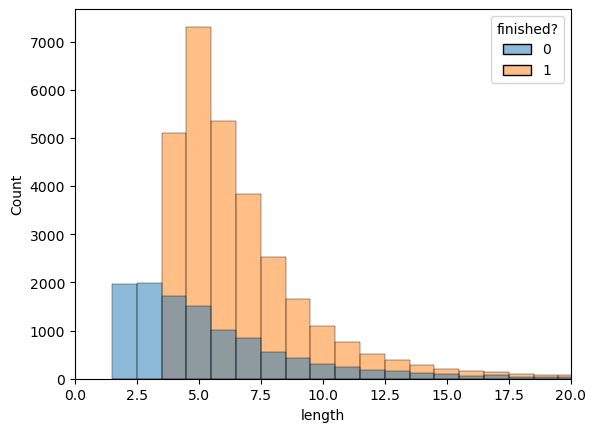

In [208]:
sns.histplot(all_games.loc[all_games.shortest_path==4], x='length', hue='finished?', discrete=True)
plt.xlim(0, 20)
# big_games.length.


In [209]:
all_games.loc[(all_games.shortest_path==2) & all_games['finished?']==1]

,start,target,path,finished?,length,game,links_to_target,log_links_to_target,shortest_path
55,2005_Atlantic_hurricane_season,Spain,"[2005_Atlantic_hurricane_season, Cuba, Spanish...",1,4,"2005_Atlantic_hurricane_season, Spain",539,6.289716,2
248,Africa,Temperate,"[Africa, African_Great_Lakes, <, Rainforest, T...",1,6,"Africa, Temperate",65,4.174387,2
250,Africa,Poverty,"[Africa, Poverty]",1,2,"Africa, Poverty",65,4.174387,2
296,Age_of_Enlightenment,Voltaire,"[Age_of_Enlightenment, Voltaire]",1,2,"Age_of_Enlightenment, Voltaire",41,3.713572,2
313,Agriculture,Barley,"[Agriculture, Barley]",1,2,"Agriculture, Barley",32,3.465736,2
...,...,...,...,...,...,...,...,...,...
51192,Periodic_table_%28large_version%29,Indium,"[Periodic_table_%28large_version%29, Indium]",1,2,"Periodic_table_%28large_version%29, Indium",9,2.197225,2
51203,Rubik%27s_Cube,Algorithm,"[Rubik%27s_Cube, Algorithm]",1,2,"Rubik%27s_Cube, Algorithm",26,3.258097,2
51204,Rubik%27s_Cube,Algorithm,"[Rubik%27s_Cube, Algorithm]",1,2,"Rubik%27s_Cube, Algorithm",26,3.258097,2
51253,Starship_Troopers,Mathematics,"[Starship_Troopers, Mathematics]",1,2,"Starship_Troopers, Mathematics",151,5.017280,2


In [260]:

fig = go.Figure()
minSP=2
x_title = 0.7; y_title = 1.3
x_sr = 1.03; y_sr = 0.5
x_giveup = x_sr; y_giveup = 0.2
x_tot = x_sr; y_tot = 0.6

success_rates = []
early_stops = []
tot_nbr_paths = []
for step in range(minSP, 8):
    datafinished = all_games.loc[(all_games.shortest_path==step) & (all_games['finished?']==1)]
    counts_f = datafinished.groupby('length').size().sort_index(ascending=True)

    fig.add_trace(
        go.Histogram(
            visible=False,
            histnorm='probability',
            marker=dict(color='rgba(25, 25, 255, 0.5)'),
            name=f'{len(datafinished.length)} finished paths',
            xbins=dict(start=np.min(datafinished.length.values),
                       size=1,
                       end=np.max(datafinished.length.values)),
            x=datafinished.length.values,
            customdata=[f"{c:>5} finished paths" for c in counts_f],
            hovertemplate='%{customdata} <extra></extra>',
        )
    )

    dataunfinished = all_games.loc[(all_games.shortest_path==step) & (all_games['finished?']==0)]
    counts_unf = dataunfinished.groupby('length').size().sort_index(ascending=True)

    early_stop = dataunfinished.loc[(dataunfinished.length<step)]
    early_stops.append(early_stop.shape[0]/dataunfinished.shape[0]*100)
    tot_nbr_paths.append(datafinished.shape[0]+dataunfinished.shape[0])
    success_rate = (datafinished.shape[0] / (datafinished.shape[0] + dataunfinished.shape[0])) * 100
    success_rates.append(success_rate)
    
    fig.add_trace(
        go.Histogram(
            visible=False,
            histnorm='probability',
            marker=dict(color='rgba(255, 25, 25, 0.5)'),
            name=f'{len(dataunfinished.length)} unfinished paths',
            xbins=dict(start=np.min(dataunfinished.length.values),
                       size=1,
                       end=np.max(dataunfinished.length.values)),
            x=dataunfinished.length.values,
            customdata=[f"{c:>5} unfinished paths" for c in counts_unf],
            hovertemplate='%{customdata} <extra></extra>',
        )
    )
 
    fig.add_trace(
        go.Scatter(
            visible=False,
            marker=dict(color='rgba(0, 0, 0, 0.5)'),
            name="shortest path",
            x=[step+0.5, step+0.5],  # Replace `10` with the desired x-values for your line
            y=[0, 1],  # Use numeric offsets
            hoverinfo='skip',
        )
    )

# Make 1st trace visible
fig.data[0].visible = True
fig.data[1].visible = True
fig.data[2].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)//3):
    step = dict(
        method="update",
        args=[{"visible": [False] * (len(fig.data))},
              {"annotations": [dict(
                        align="left",
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        y=y_sr,
                        x=x_sr,
                        xanchor="left",
                        text=f"Success rate: {success_rates[i]:>5.2f}%"),

                        dict(
                        align="left",
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        y=y_giveup,
                        x=x_giveup,
                        xanchor="left",
                        text=f"Pourcentage of failed games<br>shorter than the shortest<br>path: {early_stops[i]:>5.2f}%"),
                        
                        dict(
                        align="left",
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        y=y_tot,
                        x=x_tot,
                        xanchor="left",
                        text=f"Total number of path: {tot_nbr_paths[i]:>5.0f}"),

                        dict(
                        align="center",
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        y=y_title,
                        x=x_title,
                        font=dict(size=25),
                        xanchor="center",
                        text=f"Distribution of the players' path<br>lengths when the shortest path is {i+minSP}"), ]}
               ],  # layout attribute
        label = f'{i+minSP}',
    )
    step["args"][0]["visible"][3*i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][3*i+1] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][3*i+2] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Shortest path: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    autosize = False,
    sliders=sliders,
    barmode='overlay',
    hovermode="x unified",
    annotations=[dict(
                        align="left",
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        y=y_sr,
                        x=x_sr,
                        xanchor="left",
                        text=f"Success rate: {success_rates[0]:>8.2f}%"),
                 dict(
                        align="left",
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        y=y_giveup,
                        x=x_giveup,
                        xanchor="left",
                        text=f"Pourcentage of failed games<br>shorter than the shortest<br>path: {early_stops[0]:>8.2f}%"),

                dict(
                        align="left",
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        y=y_tot,
                        x=x_tot,
                        xanchor="left",
                        text=f"Total number of path: {tot_nbr_paths[0]:>5.0f}"),
                 dict(
                        align="center",
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        y=y_title,
                        x=x_title,
                        font=dict(size=25),
                        xanchor="center",
                        text=f"Distribution of the players' path<br>lengths when the shortest path is {minSP}")],
    
    xaxis=dict(domain=[0, 1], range=[0, 30], autorange=False),
    yaxis=dict(domain=[0, 1], range=[0, 0.7], autorange=False),
    legend_itemwidth=50,  
    margin=dict(l=20, r=80, t=100, b=30),
    width=850, height=500, font_size=16
)

fig.update_xaxes(
    title_text=f"Path length")

fig.update_yaxes(
    title_text=f"Frequency"
)

plotly_save_to_html(fig, 'distrib_path_lengths_wrt_shortest_path')

In [211]:
sum(tot_nbr_paths)
all_games.loc[(all_games.shortest_path>=3) & (all_games.length>=2)]

,start,target,path,finished?,length,game,links_to_target,log_links_to_target,shortest_path
0,14th_century,African_slave_trade,"[14th_century, 15th_century, 16th_century, Pac...",1,9,"14th_century, African_slave_trade",7,1.945910,4
1,14th_century,African_slave_trade,"[14th_century, Europe, Africa, Atlantic_slave_...",1,5,"14th_century, African_slave_trade",7,1.945910,4
2,14th_century,African_slave_trade,"[14th_century, Niger, Nigeria, British_Empire,...",1,8,"14th_century, African_slave_trade",7,1.945910,4
3,14th_century,Greece,"[14th_century, Renaissance, Ancient_Greece, Gr...",1,4,"14th_century, Greece",246,5.505332,3
4,14th_century,John_F._Kennedy,"[14th_century, Italy, Roman_Catholic_Church, H...",1,7,"14th_century, John_F._Kennedy",60,4.094345,4
...,...,...,...,...,...,...,...,...,...
24869,Turks_and_Caicos_Islands,Iraq_War,"[Turks_and_Caicos_Islands, United_States, Iraq...",0,6,"Turks_and_Caicos_Islands, Iraq_War",22,3.091042,4
24870,Franz_Kafka,Cholera,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",0,8,"Franz_Kafka, Cholera",38,3.637586,4
24872,Computer_programming,The_Beatles,"[Computer_programming, Linguistics, Culture, P...",0,5,"Computer_programming, The_Beatles",61,4.110874,4
24873,Jamaica,Alan_Turing,"[Jamaica, United_Kingdom, World_War_II, Battle...",0,4,"Jamaica, Alan_Turing",11,2.397895,4


In [212]:
all_games.loc[(all_games.shortest_path==3) & all_games['finished?']=='yes'].length.values

array([], dtype=int64)

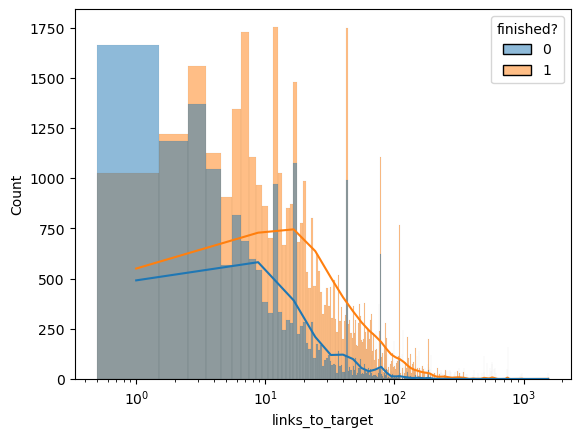

In [213]:
sns.histplot(all_games, x='links_to_target', hue='finished?', discrete=True, kde=True)
plt.xscale('log')


In [214]:
import plotly.figure_factory as ff
fig = go.Figure(layout=go.Layout(width=400, height=500, font_size=16))
minSP=3
x_title = 0.7; y_title = 1.3
x_sr = 1.03; y_sr = 0.5
x_giveup = x_sr; y_giveup = 0.2
x_tot = x_sr; y_tot = 0.6


def hist_add_trace_ltt(finished, df=all_games):
    data = df.loc[df['finished?']==finished].links_to_target

    # bins = np.round(np.concatenate((np.arange(0, 6), np.logspace(0.778, 3, 20))), 0)
    bins = np.round(np.logspace(0, 3, 20))[1:]
    hist, edges = np.histogram(data.values, bins=bins)
    
    if finished:
        n = 'finished'
        c = 'rgba(25, 25, 255, 0.5)'
        cd = [[edges[i], edges[i+1]-1, f" {hist[i]} {n} paths"] for i in range(len(hist))]
        ht = "<b> Interval: [%{customdata[0]}, %{customdata[1]}] </b> <br>" + "%{customdata[2]} <extra></extra>"
            
    else:
        n = 'unfinished'
        c = 'rgba(255, 25, 25, 0.5)'
        cd = [[edges[i], edges[i+1], f" {hist[i]} {n} paths"] for i in range(len(hist))]
        ht = "%{customdata[2]} <extra></extra>"
        # cd = [f"{n} paths" for i in range(len(hist))]

    counts = data.value_counts()
    # fig.add_trace(
    #     go.Histogram(
    #         histnorm='probability',
    #         marker=dict(color=c),
    #         name=f'{len(data)} {n} paths',
    #         xbins=dict(start=np.min(all_games.links_to_target.values),
    #                     size=1,
    #                     end=np.max(all_games.links_to_target.values)),
    #         x=all_games.loc[all_games['finished?']==finished].links_to_target,
    #         customdata=[f"{c} {n} paths" for c in counts],
    #         hovertemplate='%{customdata} <extra></extra>',
    #     )
    # )
    # bins = sorted(list(set(np.round(np.logspace(0, 3), 0))))
    fig.add_trace(
        go.Bar(
            y=hist/sum(hist),
            x=[(edges[i+1]+edges[i])*0.5 for i in range(len(edges)-1)],
            marker=dict(color=c),
            name=f'{len(data)} {n} paths',
            customdata=cd,
            hovertemplate=ht,
            width=[(edges[i+1]-edges[i]) for i in range(len(edges)-1)]
        )
    )


# fig = ff.create_distplot([all_games.loc[all_games['finished?']==0].links_to_target, all_games.loc[all_games['finished?']==1].links_to_target],
#                         ['', ''],
#                         colors=['rgba(255, 25, 25, 0.5)', 'rgba(25, 25, 255, 0.5)'],
#                         bin_size = 1,
#                         show_rug=False,
#                         show_hist=False)


hist_add_trace_ltt(1)
hist_add_trace_ltt(0)

fig.update_layout(
    barmode='overlay',
    hovermode="x unified",
    width=800, height=500, font_size=18,
    title = dict(text=f"Distribution of the number of links to the target article", x=0.5, xanchor='center'),
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.update_xaxes(
    # range=[0, 30],
    title_text=f"Number of direct links to target",
    type='log',
)

fig.update_yaxes(
    # range=[0, 0.3],
    title_text=f"Frequency"
)

plotly_save_to_html(fig, 'distrib_links_to_target')

In [215]:
from scipy.stats import ttest_ind_from_stats


finished = all_games.loc[all_games['finished?']==1].links_to_target
unfinished = all_games.loc[all_games['finished?']==0].links_to_target
ttest_ind_from_stats(finished.mean(), finished.std(), finished.shape[0], unfinished.mean(), unfinished.std(), unfinished.shape[0])



Ttest_indResult(statistic=43.565293044700105, pvalue=0.0)

# Logistic regression du désespoir

In [216]:
def sigmoid(x, beta=1):
    return 1/(1+np.exp(-beta*x))

# plt.scatter()

In [217]:
all_games.length.value_counts().sort_index()

length
2       4014
3       6580
4      11256
5      13377
6       9906
       ...  
121        1
164        1
171        1
235        1
435        1
Name: count, Length: 87, dtype: int64

In [218]:
import statsmodels.api as sm

y = all_games['finished?'].values
print(y)
log_reg = sm.Logit(y, all_games[['links_to_target', 'shortest_path']].astype(int)).fit() 
print(log_reg.summary()) 

[1 1 1 ... 0 0 0]
Optimization terminated successfully.
         Current function value: 0.569504
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                70842
Model:                          Logit   Df Residuals:                    70840
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                 0.03449
Time:                        15:41:34   Log-Likelihood:                -40345.
converged:                       True   LL-Null:                       -41786.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
links_to_target     0.0144      0.000     57.062      0.000       0.014       0.

In [219]:
import sklearn as sk
import sklearn.metrics as metrics

ypred = log_reg.predict(all_games[['links_to_target', 'shortest_path']].astype(int))

n = 50



def get_metrics(pred_proba, n):
    try:
        tmp = [[y[1]>i for y in ypred] for i in np.linspace(0, 1, 50)]
    except:
        tmp = [[y>i for y in ypred] for i in np.linspace(0, 1, 50)]
    r2 = [metrics.r2_score(all_games[['finished?']].values.flatten(), t) for t in tmp]
    acc = [metrics.accuracy_score(all_games[['finished?']].values.flatten(), t) for t in tmp]
    prec = [metrics.precision_score(all_games[['finished?']].values.flatten(), t) for t in tmp]
    rec = [metrics.recall_score(all_games[['finished?']].values.flatten(), t) for t in tmp]
    f1 = [metrics.f1_score(all_games[['finished?']].values.flatten(), t) for t in tmp]

    return acc, prec, rec, f1, r2



In [220]:

def plot_metrics(acc, prec, rec, f1):
    fig = go.Figure()

    def plot_metric(val, x, name, fig):
        fig.add_trace(go.Scatter(
            x = x,
            y = val,
            name = name,
            mode = 'lines'
        ))


    plot_metric(acc, x, 'accuracy', fig)
    plot_metric(rec, x, 'recall', fig)
    plot_metric(prec, x, 'precision', fig)
    plot_metric(f1, x, 'f1-score', fig)


    fig.update_layout(
        barmode='overlay',
        hovermode="x unified",
        width=800, height=500, font_size=18,
        title = dict(text=f"Metrics depending on the threshold value used", x=0.5, xanchor='center'),
        margin=dict(l=20, r=20, t=50, b=20)  
    )

    fig.update_xaxes(
        title_text=f"Threshold")

    fig.update_yaxes(
        title_text=f"Metric"
    )

    plotly_save_to_html(fig, 'metrics_log_reg')

    print(max(acc))


acc, prec, rec, f1, r2 = get_metrics(ypred, n)
plot_metrics(acc, rec, prec, f1)

r2

/bin/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



ValueError: 
    Invalid value of type 'builtins.int' received for the 'x' property of scatter
        Received value: 4

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [ ]:
import statsmodels.api as sm

y = all_games['finished?'].values
print(y)
log_reg = sm.Logit(y, all_games[['log_links_to_target', 'shortest_path']].astype(int)).fit() 
print(log_reg.summary()) 

[1 1 1 ... 0 0 0]
Optimization terminated successfully.
         Current function value: 0.551933
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                70842
Model:                          Logit   Df Residuals:                    70840
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.06428
Time:                        20:58:56   Log-Likelihood:                -39100.
converged:                       True   LL-Null:                       -41786.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
log_links_to_target     0.4909      0.006     84.109      0.000       0.

In [ ]:
ypred = log_reg.predict(all_games[['log_links_to_target', 'shortest_path']].astype(int))

acc, prec, rec, f1, r2 = get_metrics(ypred, n)
plot_metrics(acc, rec, prec, f1)

/bin/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/bin/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.7329126789192851


In [ ]:
import statsmodels.api as sm
import sklearn.linear_model as lm

y = all_games['finished?'].values
X = all_games[['links_to_target', 'shortest_path']].astype(int).values
log_reg = lm.LogisticRegression(penalty='l1', solver='liblinear').fit(X, y) 



In [ ]:
ypred.values

array([0.56766948, 0.56766948, 0.56766948, ..., 0.85133333, 0.68206218,
       0.77802278])

In [ ]:

ypred = log_reg.predict_proba(X)
acc, prec, rec, f1, r2 = get_metrics(ypred, n)
plot_metrics(acc, rec, prec, f1)

/bin/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.7306541317297648


In [ ]:
import statsmodels.api as sm
import sklearn.linear_model as lm

y = all_games['finished?'].values
X = all_games[['log_links_to_target', 'shortest_path']].astype(int).values
print(y)
log_reg = lm.LogisticRegression(penalty='l1', solver='liblinear').fit(X, y) 



[1 1 1 ... 0 0 0]


In [ ]:

ypred = log_reg.predict_proba(X)
acc, prec, rec, f1, r2 = get_metrics(ypred, n)
plot_metrics(acc, rec, prec, f1)


/bin/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/bin/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.735213573868609


In [ ]:
r2

[-0.38263364365595187,
 -0.38263364365595187,
 -0.38263364365595187,
 -0.38263364365595187,
 -0.38263364365595187,
 -0.38263364365595187,
 -0.38263364365595187,
 -0.38263364365595187,
 -0.38263364365595187,
 -0.38150525098579147,
 -0.38150525098579147,
 -0.38150525098579147,
 -0.38150525098579147,
 -0.3776264011821149,
 -0.3776264011821149,
 -0.3776264011821149,
 -0.3767801066794947,
 -0.35103864889145986,
 -0.35103864889145986,
 -0.35103864889145986,
 -0.35103864889145986,
 -0.3456787837081978,
 -0.3228993566793341,
 -0.3228993566793341,
 -0.3228993566793341,
 -0.3241687984332646,
 -0.3525196642710453,
 -0.35985421662708816,
 -0.35985421662708816,
 -0.3599247411689732,
 -0.43080190576342514,
 -0.5398328475176768,
 -0.5435001236956982,
 -0.5435001236956982,
 -0.574178299415685,
 -0.9031047627674502,
 -0.9230632081209129,
 -0.9328661194429315,
 -1.38781993914324,
 -1.4686410641434806,
 -1.4708978494838014,
 -2.0015245026267436,
 -2.007025416893776,
 -2.3600007490283352,
 -2.374669853740